In [37]:
%matplotlib inline

from collections import namedtuple
import numpy as np
from matplotlib import pyplot as plt
import time
import tt

def rs(f1, f2, f, vx_, N):
    for j in range(N):
        if (vx_[j] > 0.):
            f[j, :, :] = vx_[j] * f1[j, :, :]
        else:
            f[j, :, :] = vx_[j] * f2[j, :, :]
    return f
    
def F_m(vx, vy, vz, T, n, p):
    return n * ((1. / (2. * np.pi * p.Rg * T)) ** (3. / 2.)) * (np.exp(-(vx*vx + vy*vy + vz*vz) / (2. * p.Rg * T)))

def J(f, vx, vy, vz, hv, N, p):

    n = (hv ** 3) * np.sum(f)

    ux = (1. / n) * (hv ** 3) * np.sum(vx * f)
    uy = (1. / n) * (hv ** 3) * np.sum(vy * f)
    uz = (1. / n) * (hv ** 3) * np.sum(vz * f)
    
    v2 = vx*vx + vy*vy + vz*vz
    u2 = ux*ux + uy*uy + uz*uz
    
    T = (1. / (3. * n * p.Rg)) * ((hv ** 3) * np.sum(v2 * f) - n * u2)

    Vx = vx - ux
    Vy = vy - uy
    Vz = vz - uz

    rho = p.m * n

    P = rho * p.Rg * T

    cx = Vx / ((2. * p.Rg * T) ** (1. / 2.))
    cy = Vy / ((2. * p.Rg * T) ** (1. / 2.))
    cz = Vz / ((2. * p.Rg * T) ** (1. / 2.))
    
    c2 = cx*cx + cy*cy + cz*cz

    Sx = (1. / n) * (hv ** 3) * np.sum(cx * c2 * f)
    Sy = (1. / n) * (hv ** 3) * np.sum(cy * c2 * f)
    Sz = (1. / n) * (hv ** 3) * np.sum(cz * c2 * f)

    mu = p.mu_0 * ((p.T_0 + p.C) / (T + p.C)) * ((T / p.T_0) ** (3. / 2.))

    f_plus = F_m(Vx, Vy, Vz, T, n, p) * (1. + (4. / 5.) * (1. - p.Pr) * (cx*Sx + cy*Sy + cz*Sz) * (c2 - (5. / 2.)))

    J = (f_plus - f) * (P / mu)
    
    nu = P / mu
    
    return J, n, ux, T, nu

def solver(x_l, x_r, L, Tau, CFL, vmax, N, n_l, u_l, T_l, p):

    h = (x_r - x_l) / L 
    tau = h * CFL / vmax / 10
    
    x = np.linspace(x_l+h/2, x_r-h/2, L)
    
    t = 0.
    
    hv = 2. * vmax / N
    vx_ = np.linspace(-vmax+hv/2, vmax-hv/2, N)
    vx, vy, vz = np.meshgrid(vx_, vx_, vx_, indexing='ij')
    
    vx_l = np.zeros((N, N, N))
    vx_r = np.zeros((N, N, N))
    
    for i in np.ndindex(vx.shape):
        if vx[i] > 0:
            vx_l[i] = vx[i]
            vx_r[i] = 0.
        else:
            vx_l[i] = 0.
            vx_r[i] = vx[i]
    
    M = u_l / ((p.g * p.Rg * T_l) ** .5)
    
    n_r = (p.g + 1.) * M * M / ((p.g - 1.) * M * M + 2.) * n_l
    u_r = ((p.g - 1.) * M * M + 2.) / ((p.g + 1.) * M * M) * u_l
    T_r = (2. * p.g * M * M - (p.g - 1.)) * ((p.g - 1.) * M * M + 2.) / ((p.g + 1) ** 2 * M * M) * T_l
    
    
    F_l = F_m(vx-u_l, vy, vz, T_l, n_l, p)
    F_r = F_m(vx-u_r, vy, vz, T_r, n_r, p)
    
    
    # initial condition 
    f = np.zeros((L, N, N, N))
    for i in range(L/2+1):
        f[i, :, :, :] = F_l
    for i in range(L/2+1, L):
        f[i, :, :, :] = F_r
    
    slope = np.zeros((L, N, N, N))
    tmp = np.zeros((L, N, N, N))
    f_l = np.zeros((L+1, N, N, N))
    f_r = np.zeros((L+1, N, N, N))
    Flow = np.zeros((L+1, N, N, N))
    RHS = np.zeros((L, N, N, N))
    j = np.zeros((L, N, N, N))
    
    Dens = np.zeros(L)
    Vel = np.zeros(L)
    Temp = np.zeros(L)
    
    Frob_norm_RHS = np.zeros(L)
    Frob_norm_iter = np.array([])
    
    t1 = time.clock()
    
    while(t < Tau*tau):
        t += tau
        # boundary condition
        f_l[0, :, :, :] = F_l
        f_r[L, :, :, :] = F_r
        # reconstruction
        # compute slopes
        
        for i in range(1, L-1):
            slope[i, :, :, :] = h * (f[i+1, :, :, :] - 2 * f[i, :, :, :] + f[i-1, :, :, :])
#            slope[i, :, :, :] = h * minmod(f[i+1, :, :, :] - f[i, :, :, :], f[i, :, :, :] - f[i-1, :, :, :])
            
        for i in range(L):
            f_r[i, :, :, :] = f[i, :, :, :] - (h / 2) * slope[i, :, :, :]
        
        for i in range(1, L+1):
            f_l[i, :, :, :] = f[i-1, :, :, :] + (h / 2) * slope[i-1, :, :, :]
        
        # riemann solver - compute fluxes
        for i in range(L+1):
            Flow[i, :, :, :] = rs(f_l[i, :, :, :], f_r[i, :, :, :], Flow[i, :, :, :], vx_, N)
            
        
            
        # compute RHS
        for i in range(L):
            RHS[i, :, :, :] = (- Flow[i+1, :, :, :] + Flow[i, :, :, :]) / h + J(f[i, :, :, :], vx, vy, vz, hv, N, p)[0]
#            Frob_norm = np.append(Frob_norm, np.linalg.norm(RHS))
#            C_norm = np.append(C_norm, np.max(np.absolute(np.ravel(RHS))))
            
#        nu = 

	Frob_norm_iter = np.append(Frob_norm_iter, sum([np.linalg.norm(RHS[i]) for i in range(L)]))

        # update values
        for i in range(L):
            tmp[i, :, :, :] = f[i, :, :, :] + tau * RHS[i, :, :, :]
                
        f = tmp
        
#        print np.linalg.norm(RHS)
#        print np.max(np.absolute((j)))
        
     
        
    t2 = time.clock() - t1
    Dens = np.zeros(L)
    Vel = np.zeros(L)
    Temp = np.zeros(L)
    
    for i in range(L):
        Dens[i] = J(f[i, :, :, :], vx, vy, vz, hv, N, p)[1]
        Vel[i] = J(f[i, :, :, :], vx, vy, vz, hv, N, p)[2]
        Temp[i] = J(f[i, :, :, :], vx, vy, vz, hv, N, p)[3]
        
    print "time =", t2 / 3600, "h", (t2 % 3600) / 60, "m", t2 % 60, "s"
    
#    fig, ax = plt.subplots(figsize = (20,10))
#    line, = ax.semilogy(Frob_norm)
#    line.set_label('Frob_norm')
#    line, = ax.semilogy(C_norm)
#    line.set_label('C_norm')
#    ax.legend()
    
    l = 1. / ((2 ** .5) * np.pi * n_l * p.d * p.d)
        
    delta = l / (n_r - n_l) * np.max(Dens[1:] - Dens[:-1]) / (2 * h)

    for i in range(L):
        Frob_norm_RHS[i] = np.linalg.norm(RHS[i])
    
    Return = namedtuple('Return', ['f', 'Dens', 'Vel', 'Temp', 'delta', 'Frob_norm_iter', 'Frob_norm_RHS'])
    
    S = Return(f, Dens, Vel, Temp, delta, Frob_norm_iter, Frob_norm_RHS)
    
    return S

In [38]:
def rs_tt(f1, f2, vx_l, vx_r):
    return vx_l * f1 + vx_r * f2

def J_tt(f, vx, vy, vz, vx_tt, vy_tt, vz_tt, hv, N, r, p):
    
    n = (hv ** 3) * tt.sum(f)

    ux = (1. / n) * (hv ** 3) * tt.sum(vx_tt * f)
    uy = (1. / n) * (hv ** 3) * tt.sum(vy_tt * f)
    uz = (1. / n) * (hv ** 3) * tt.sum(vz_tt * f)
    
    v2 = (vx_tt*vx_tt + vy_tt*vy_tt + vz_tt*vz_tt).round(r)
    u2 = ux*ux + uy*uy + uz*uz
    
    T = (1. / (3. * n * p.Rg)) * ((hv ** 3) * tt.sum(v2 * f) - n * u2)

    Vx = vx - ux
    Vy = vy - uy
    Vz = vz - uz
    
    Vx_tt = (vx_tt - ux * tt.ones((N,N,N))).round(r)
    Vy_tt = (vy_tt - uy * tt.ones((N,N,N))).round(r)
    Vz_tt = (vz_tt - uz * tt.ones((N,N,N))).round(r)

    rho = p.m * n

    P = rho * p.Rg * T

    cx = Vx_tt * (1. / ((2. * p.Rg * T) ** (1. / 2.)))
    cy = Vy_tt * (1. / ((2. * p.Rg * T) ** (1. / 2.)))   
    cz = Vz_tt * (1. / ((2. * p.Rg * T) ** (1. / 2.)))
    
    c2 = (cx*cx + cy*cy + cz*cz).round(r)

    Sx = (1. / n) * (hv ** 3) * tt.sum(cx * c2 * f)
    Sy = (1. / n) * (hv ** 3) * tt.sum(cy * c2 * f)
    Sz = (1. / n) * (hv ** 3) * tt.sum(cz * c2 * f)

    mu = p.mu_0 * ((p.T_0 + p.C) / (T + p.C)) * ((T / p.T_0) ** (3. / 2.))

    F_M = tt.tensor(F_m(Vx, Vy, Vz, T, n, p))
    
    f_plus = F_M * (tt.ones((N,N,N)) + (4. / 5.) * (1. - p.Pr) * (cx*Sx + cy*Sy + cz*Sz) * (c2 - (5. / 2.) * tt.ones((N,N,N))))
    f_plus = f_plus.round(r)
    
    J = (f_plus - f) * (P / mu)
    J = J.round(r)
    
    nu = P / mu
    
    return J, n, ux, T, nu

def save_tt(filename, f, L, N):
    
    m = max(f[i].core.size for i in range(L))

    F = np.zeros((m+4, L))
    
    for i in range(L):
        F[:4, i] = f[i].r.ravel()
        F[4:f[i].core.size+4, i] = f[i].core.ravel()
    
        np.savetxt(filename, F)#, fmt='%s')
    
def load_tt(filename, L, N):
    
    F = np.loadtxt(filename)
    
    f = list()
    
    for i in range(L):
        
        f.append(tt.rand([N, N, N], 3, F[:4, i]))
        f[i].core = F[4:f[i].core.size+4, i]
        
    return f

In [39]:
def solver_tt(x_l, x_r, L, Tau, CFL, vmax, N, n_l, u_l, T_l, r, p, filename, init = '0'):
    
    h = (x_r - x_l) / L 
    tau = h * CFL / vmax / 10
    
    x = np.linspace(x_l+h/2, x_r-h/2, L)
    
    t = 0.
    
    hv = 2. * vmax / N
    vx_ = np.linspace(-vmax+hv/2, vmax-hv/2, N)
    vx, vy, vz = np.meshgrid(vx_, vx_, vx_, indexing='ij')
    
    vx_l = np.zeros((N, N, N))
    vx_r = np.zeros((N, N, N))
    
    for i in np.ndindex(vx.shape):
        if vx[i] > 0:
            vx_l[i] = vx[i]
        else:
            vx_l[i] = 0.
            
    vx_r = vx - vx_l
            
    vx_l = tt.tensor(vx_l)
    vx_r = tt.tensor(vx_r)
    
    vx_tt = tt.tensor(vx)
    vy_tt = tt.tensor(vy)
    vz_tt = tt.tensor(vz)
    
    M = u_l / ((p.g * p.Rg * T_l) ** .5)
    
    n_r = (p.g + 1.) * M * M / ((p.g - 1.) * M * M + 2.) * n_l
    u_r = ((p.g - 1.) * M * M + 2.) / ((p.g + 1.) * M * M) * u_l
    T_r = (2. * p.g * M * M - (p.g - 1.)) * ((p.g - 1.) * M * M + 2.) / ((p.g + 1) ** 2 * M * M) * T_l
    
    
    F_l = tt.tensor(F_m(vx-u_l, vy, vz, T_l, n_l, p))
    F_r = tt.tensor(F_m(vx-u_r, vy, vz, T_r, n_r, p))
    
#    vx = tt.tensor(vx)
#    vy = tt.tensor(vy)
#    vz = tt.tensor(vz)
    
    # initial condition 
#    f = list(F_l for i in range(L/2+1))
#    f = f.extend(list(F_r for i in range(L/2+1, L)))

    f = list(tt.tensor(np.zeros((N, N, N))) for i in range(L))
        
#    for i in range(L):
#        f[i] = tt.tensor(f[i])
    
    slope = list(0. * tt.ones((N,N,N)) for i in range(L))
    tmp = list(0. * tt.ones((N,N,N)) for i in range(L))
    f_l = list(0. * tt.ones((N,N,N)) for i in range(L+1))
    f_r = list(0. * tt.ones((N,N,N)) for i in range(L+1))
    Flow = list(0. * tt.ones((N,N,N)) for i in range(L+1))
    RHS = list(0. * tt.ones((N,N,N)) for i in range(L))
    j = list(0. for i in range(L))
    jj = list(0. * tt.ones((N,N,N)) for i in range(L))
    

    Frob_norm_RHS = np.zeros(L)
    Frob_norm_iter = np.array([])
#    C_norm_iter = np.array([])

    if (init == '0'):
        for i in range(L/2+1):
            f[i] = F_l
        for i in range(L/2+1, L):
            f[i] = F_r
            
    else:
        f = load_tt(init, L, N)
        
    t1 = time.clock()
    
    while(t < Tau*tau):
        t += tau
        # boundary condition
        f_l[0] = F_l
        f_r[L] = F_r
        # reconstruction
        # compute slopes
        
        for i in range(1, L-1):
            slope[i] = h * (f[i+1] - 2 * f[i] + f[i-1])
            slope[i] = slope[i].round(r)
#            print slope[i] + f[i]
#            slope[i] = slope[i].round(rmax=150)
            # insert ROUNDING!!!
#            slope[i, :, :, :] = h * minmod(f[i+1, :, :, :] - f[i, :, :, :], f[i, :, :, :] - f[i-1, :, :, :])
            
        for i in range(L):
            f_r[i] = f[i] - slope[i] * (h / 2)
            f_r[i] = f_r[i].round(r)
        
        for i in range(1, L+1):
            f_l[i] = f[i-1] + (h / 2) * slope[i-1]
            f_l[i] = f_l[i].round(r)
        
        # riemann solver - compute fluxes
        for i in range(L+1):
            Flow[i] = rs_tt(f_l[i], f_r[i], vx_l, vx_r)
            Flow[i] = Flow[i].round(r)
            
        # compute RHS
        for i in range(L):
            j[i] = J_tt(f[i], vx, vy, vz, vx_tt, vy_tt, vz_tt, hv, N, r, p)
            jj[i] = j[i][0]
            RHS[i] = (- Flow[i+1] + Flow[i]) * (1. / h) + jj[i]
            RHS[i] = RHS[i].round(r)
            
        nu = max(j[i][4] for i in range(L))
        
#        if (((t/tau) % 100) == 1):
#            for i in range(L):
#                Frob_norm_RHS[i] = RHS[i].norm()
                
                
#            fig, ax = plt.subplots(figsize = (20,10))
#            ax.semilogy(Frob_norm_RHS)

#            ax.set(title='RHS frob norm')

#            fig.savefig("RHS.png")
            
        Frob_norm_iter = np.append(Frob_norm_iter, sum([RHS[i].norm() for i in range(L)]))

        # update values
        for i in range(L):
            tmp[i] = f[i] + tau * RHS[i]
            tmp[i] = tmp[i].round(r)
            
        for i in range(L):    
            f[i] = tmp[i]
        
#        print np.linalg.norm(RHS)
#        print np.max(np.absolute((j)))
        
     
        
    t2 = time.clock() - t1
    
    t2 = int(round(t2))
    
    print "time =", t2 / 3600, "h", (t2 % 3600) / 60, "m", t2 % 60, "s"
    
    Dens = np.zeros(L)
    Vel = np.zeros(L)
    Temp = np.zeros(L)



    for i in range(L):
        
        Dens[i] = j[i][1]
        Vel[i] = j[i][2]
        Temp[i] = j[i][3]
        
    l = 1. / ((2 ** .5) * np.pi * n_l * p.d * p.d)
        
    delta = l / (n_r - n_l) * np.max(Dens[1:] - Dens[:-1]) / (2 * h)
    
    save_tt(filename, f, L, N)
    
    for i in range(L):
        Frob_norm_RHS[i] = RHS[i].norm()

    
#    print nu

    Return = namedtuple('Return', ['f', 'Dens', 'Vel', 'Temp', 'delta', 'Frob_norm_iter', 'Frob_norm_RHS'])
    
    S = Return(f, Dens, Vel, Temp, delta, Frob_norm_iter, Frob_norm_RHS)
    
    return S

Max = 1.24076051934
Dens
-4.6370882846720004e-11
-2.7884899333142083e-10
Vel
-1.935953264364798e-10
-1.6766527134545288e-09
Temp
-5.069658470802097e-10
-4.679876538538696e-09


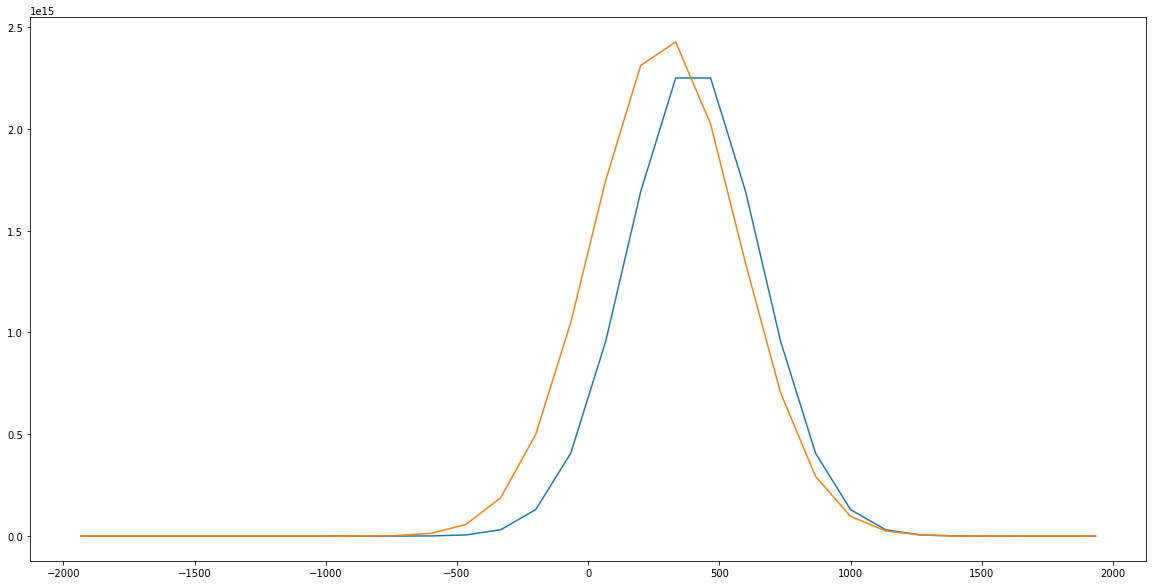

In [4]:
class Params(object):
 
    def __init__(self):
        #fundamental constants
        self.Na = 6.02214129e+23
        self.kB = 1.381e-23 # J / K
        #gas parameters
        self.Mol = 40e-3 # kg / mol
        self.Rg = 8.3144598  / self.Mol  # J / (kg * K) 
        self.m = self.Mol / self.Na # kg
    
        self.Pr = 2. / 3.
        self.C = 144.4
        self.T_0 = 273.11
        self.mu_0 = 2.125e-05
    
        self.g = 5. / 3.
        
        self.d = 71e-12

p = Params()

L = 30
N = 30
vmax = 2000.

n_l = 2e+23 
u_l = 400.
T_l = 300.

M = u_l / ((p.g * p.Rg * T_l) ** .5)

n_r = (p.g + 1.) * M * M / ((p.g - 1.) * M * M + 2.) * n_l
u_r = ((p.g - 1.) * M * M + 2.) / ((p.g + 1.) * M * M) * u_l
T_r = (2. * p.g * M * M - (p.g - 1.)) * ((p.g - 1.) * M * M + 2.) / ((p.g + 1) ** 2 * M * M) * T_l

l = 1. / ((2 ** .5) * np.pi * n_l * p.d * p.d)

x_l = -20*l
x_r = 20*l

h = (x_r - x_l) / L

x = np.linspace(x_l+h/2, x_r-h/2, L) / l

#x_l = -20*l
#x_r = 20*l

Tau = 101

CFL = 0.5

r = 1e-7

print 'Max =', M

hv = 2. * vmax / N
vx_ = np.linspace(-vmax+hv/2, vmax-hv/2, N)
vx, vy, vz = np.meshgrid(vx_, vx_, vx_, indexing='ij')

M_l = F_m(vx-u_l, vy, vz, T_l, n_l, p)
M_r = F_m(vx-u_r, vy, vz, T_r, n_r, p)


print 'Dens'
print (J(M_l, vx, vy, vz, hv, N, p)[1] - n_l) / n_l
print (J(M_r, vx, vy, vz, hv, N, p)[1] - n_r) / n_r

print 'Vel'
print (J(M_l, vx, vy, vz, hv, N, p)[2] - u_l) / u_l
print (J(M_r, vx, vy, vz, hv, N, p)[2] - u_r) / u_r

print 'Temp'
print (J(M_l, vx, vy, vz, hv, N, p)[3] - T_l) / u_l
print (J(M_r, vx, vy, vz, hv, N, p)[3] - T_r) / u_r


M_l_0 = M_l[:, N/2+1, N/2+1] + M_l[:, N/2, N/2+1] + M_l[:, N/2+1, N/2] + M_l[:, N/2, N/2]
M_r_0 = M_r[:, N/2+1, N/2+1] + M_r[:, N/2, N/2+1] + M_r[:, N/2+1, N/2] + M_r[:, N/2, N/2]
fig, ax = plt.subplots(figsize = (20,10))
line, = ax.plot(vx_, M_l_0)
line, = ax.plot(vx_, M_r_0)

time = 0 h 1 m 36 s


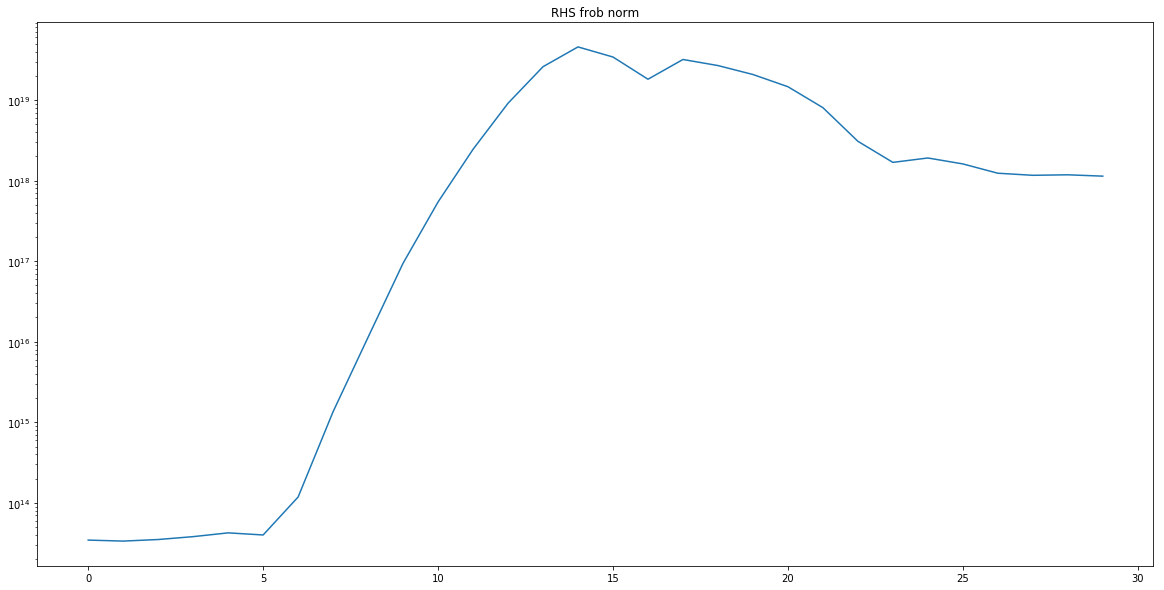

In [32]:
S_tt = solver_tt(x_l = x_l, x_r = x_r, L = L, Tau = Tau, CFL = CFL, vmax = vmax,
           N = N, n_l = n_l, u_l = u_l, T_l = T_l, r = r, p = p, filename = 'M1-24.txt',
                 init = 'M1-24.txt')

delta = 0.09900525245981853


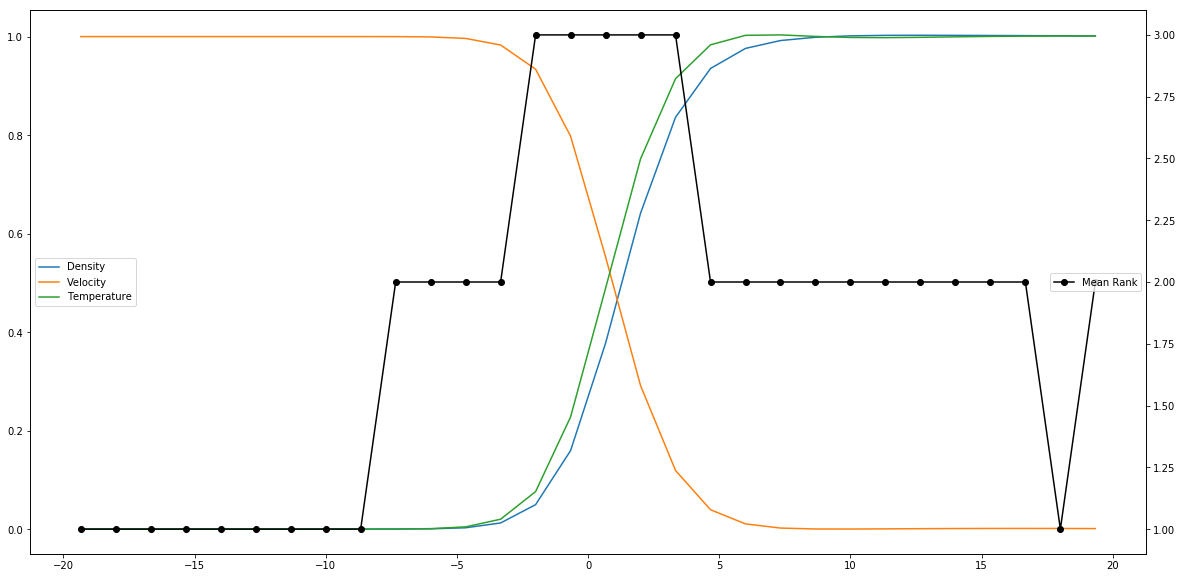

In [33]:
print 'delta =', S_tt.delta
fig, ax = plt.subplots(figsize = (20,10))
line, = ax.plot(x, (S_tt.Dens - n_l) / (n_r - n_l))
line.set_label('Density')
line, = ax.plot(x, (S_tt.Vel - u_r) / (u_l - u_r))
line.set_label('Velocity')
line, = ax.plot(x, (S_tt.Temp - T_l) / (T_r - T_l))
line.set_label('Temperature')

s = np.zeros(L)
for i in range(L):
    s[i] = (S_tt.f[i].r[1] + S_tt.f[i].r[2]) / 2.
    
#s = (s - np.min(s)) / (np.max(s) - np.min(s))

ax1 = ax.twinx()
line, = ax1.plot(x, s, 'ko-')
line.set_label('Mean Rank')

ax.legend(loc=6)
ax1.legend(loc=7)
plt.show()

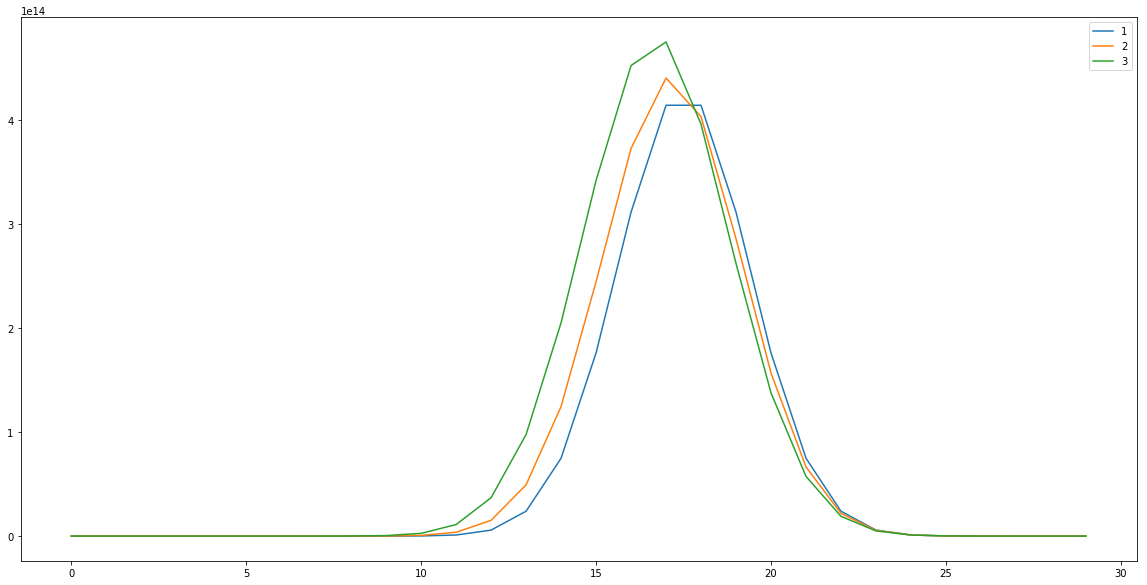

In [34]:
X1 = ((S_tt.f[0]).full())[:, N/2+1, N/2+1]
X2 = ((S_tt.f[L/2]).full())[:, N/2+1, N/2+1]
X3 = ((S_tt.f[L-1]).full())[:, N/2+1, N/2+1]

fig, ax = plt.subplots(figsize = (20,10))
line, = ax.plot(X1)#,'ko-')
line.set_label('1')
line, = ax.plot(X2)
line.set_label('2')
line, = ax.plot(X3)
line.set_label('3')
ax.legend()

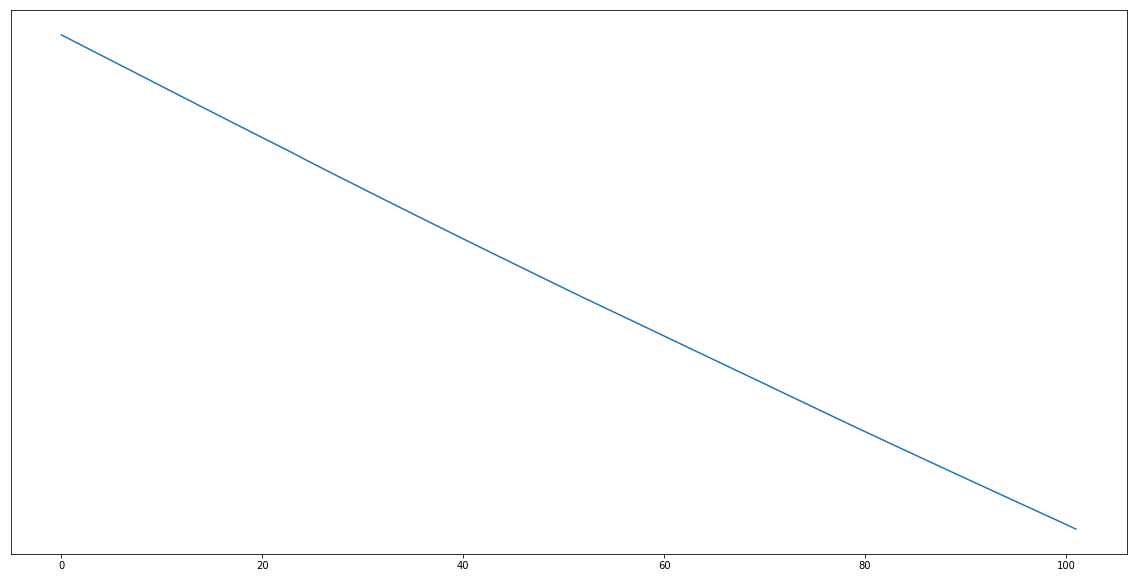

In [35]:
fig, ax = plt.subplots(figsize = (20,10))
line, = ax.semilogy(S_tt.Frob_norm_iter)#,'ko-')

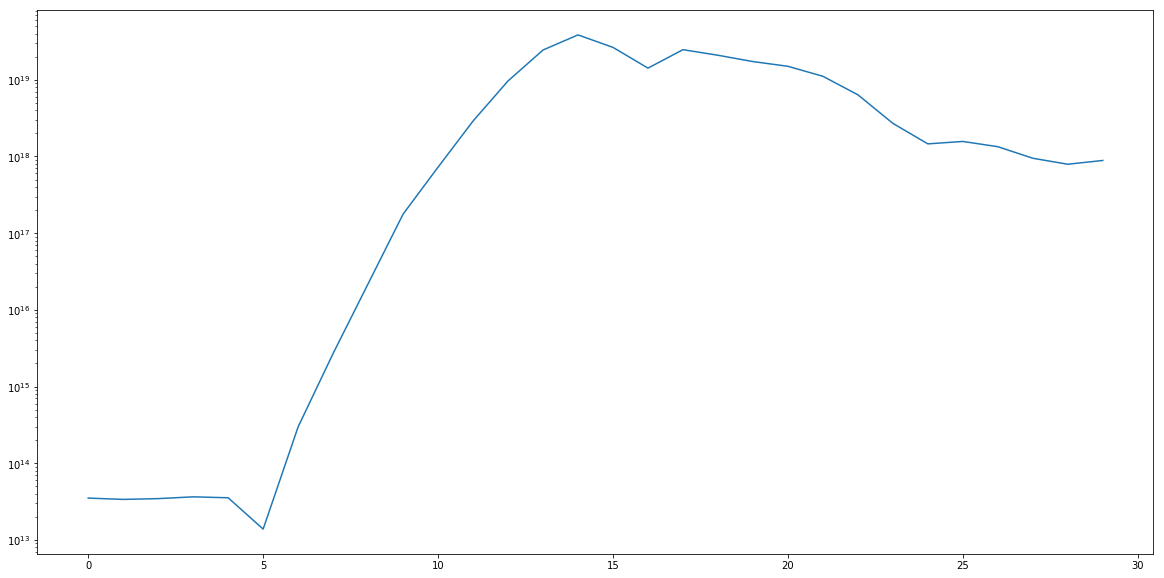

In [36]:
fig, ax = plt.subplots(figsize = (20,10))
line, = ax.semilogy(S_tt.Frob_norm_RHS)#,'ko-')